#### <a>Objective: To develop a customer segmentation to define marketing strategy and use the derived KPIs to gain insight on the customer profiles and provide the strategic insights and implementation of strategies.

#### <a> Business Context:</a>

This case requires trainees to develop a customer segmentation to define marketing strategy. The sample dataset summarizes the usage behavior of about 9000 active credit card holders during the last 6 months. The file is at a customer level with 18 behavioral variables.


#### <a> Data Dictionary:</a>

CUST_ID: Credit card holder ID<br>
BALANCE: Monthly average balance (based on daily balance averages)<br>
BALANCE_FREQUENCY: Ratio of last 12 months with balance<br>
PURCHASES: Total purchase amount spent during last 12 months<br>
ONEOFF_PURCHASES: Total amount of one-off purchases<br>
INSTALLMENTS_PURCHASES: Total amount of installment purchases<br>
CASH_ADVANCE: Total cash-advance amount<br>
PURCHASES_ FREQUENCY: Frequency of purchases (Percent of months with at least one purchase)<br>
ONEOFF_PURCHASES_FREQUENCY: Frequency of one-off-purchases<br>
PURCHASES_INSTALLMENTS_FREQUENCY: Frequency of installment purchases<br>
CASH_ADVANCE_ FREQUENCY: Cash-Advance frequency<br>
AVERAGE_PURCHASE_TRX: Average amount per purchase transaction<br>
CASH_ADVANCE_TRX: Average amount per cash-advance transaction<br>
PURCHASES_TRX: Average amount per purchase transaction<br>
CREDIT_LIMIT: Credit limit<br>
PAYMENTS: Total payments (due amount paid by the customer to decrease their statement balance) in the period<br>
MINIMUM_PAYMENTS: Total minimum payments due in the period<br>
PRC_FULL_PAYMEN: Percentage of months with full payment of the due statement balance<br>
TENURE: Number of months as a customer
    
<b><a>Data Source:</a></b> https://www.kaggle.com/arjunbhasin2013/ccdata 

#### <a> Importing Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy.cluster import hierarchy as sch
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import silhouette_score

from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

#### <a>Defining User Defined Functions (UDFs)

In [2]:
#Function for getting statistical information of continuous variables
def continuous_var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  
                      x.std(), x.var(), x.min(), x.quantile(0.01), x.quantile(0.99), x.max()], 
                  index = ['COUNT', 'MISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1', 
                                'P99' ,'MAX'])

In [3]:
#Function for getting statistical information of categorical variables
def categorical_var_summary(x):
    Mode = x.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([x.count(), len(np.unique(x)), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                      round(((Mode.iloc[0, 1] * 100)/x.count()), 2)], 
                      index = ['COUNT', 'UNIQUE', 'MISS', 'MODE', 'FREQ', 'PERCENT'])

In [4]:
#Function for creating dummy variables
def dummy_var(df, col):
    dummies = pd.get_dummies(df[col], prefix = col)
    df = pd.concat([df, dummies], axis = 1)
    df.drop(col, axis = 1, inplace = True )
    return df

In [5]:
#Outlier treatment function
def outlier_capping(x):
    x = x.clip(lower = x.quantile(0.05),upper = x.quantile(0.95))
    return x

#### <a>Loading Data

In [6]:
data = pd.read_csv('CC_GENERAL.csv')

#### <a>Understanding Data

In [7]:
#Data View
data.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [8]:
#Data information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

#### <a>Statistical Summary

In [9]:
#Continous Variable Summary
data.select_dtypes(['int64','float64']).apply(continuous_var_summary)

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
COUNT,8.950000e+03,8950.000000,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8.949000e+03,8.950000e+03,8.637000e+03,8950.000000,8950.000000
MISS,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+00,0.000000e+00,3.130000e+02,0.000000,0.000000
SUM,1.400205e+07,7851.572994,8.978683e+06,5.302314e+06,3.679055e+06,8.760896e+06,4388.637408,1811.996268,3261.714207,1209.540593,29077.000000,131653.000000,4.022083e+07,1.551164e+07,7.464152e+06,1375.746104,103080.000000
MEAN,1.564475e+03,0.877271,1.003205e+03,5.924374e+02,4.110676e+02,9.788711e+02,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4.494449e+03,1.733144e+03,8.642065e+02,0.153715,11.517318
MEDIAN,8.733852e+02,1.000000,3.612800e+02,3.800000e+01,8.900000e+01,0.000000e+00,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3.000000e+03,8.569015e+02,3.123439e+02,0.000000,12.000000
STD,2.081532e+03,0.236904,2.136635e+03,1.659888e+03,9.043381e+02,2.097164e+03,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3.638816e+03,2.895064e+03,2.372447e+03,0.292499,1.338331
VAR,4.332775e+06,0.056124,4.565208e+06,2.755228e+06,8.178274e+05,4.398096e+06,0.161098,0.089004,0.157965,0.040049,46.575803,617.902719,1.324098e+07,8.381394e+06,5.628503e+06,0.085556,1.791129
MIN,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000e+01,0.000000e+00,1.916300e-02,0.000000,6.000000
P1,6.510059e-02,0.090909,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000e+02,0.000000e+00,1.952448e+01,0.000000,6.000000
P99,9.338805e+03,1.000000,8.977290e+03,6.689898e+03,3.886241e+03,9.588163e+03,1.000000,1.000000,1.000000,0.833333,29.000000,116.510000,1.700000e+04,1.360872e+04,9.034099e+03,1.000000,12.000000


In [10]:
#Categorical Variable Summary
data[['CUST_ID']].apply(categorical_var_summary)

,CUST_ID
COUNT,8950
UNIQUE,8950
MISS,0
MODE,C17692
FREQ,1
PERCENT,0.01


Based on Statistical Summary, dataset contains missing values and outliers which needs to be treated accordingly.

#### <a>Data Preparation

In [11]:
#Based on Statistical Summary dropping CUST_ID
data.drop('CUST_ID', axis = 1, inplace = True)

In [12]:
#Missing values
data.isna().sum()

BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

In [13]:
#Treating Missing values
data.CREDIT_LIMIT.fillna(data.CREDIT_LIMIT.median(), inplace = True)
data.MINIMUM_PAYMENTS.fillna(data.MINIMUM_PAYMENTS.median(), inplace = True)

In [14]:
#Checking again for missing values
data.isna().sum()

BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

In [15]:
#Treating Outliers
data = data.apply(outlier_capping)

In [16]:
#Checking for duplicates rows
data.duplicated().sum()

1

In [17]:
#Dropping duplicate row
data.drop_duplicates(inplace = True)
data = data.reset_index(drop = True)

#### <a> Deriving KPIs

In [18]:
data['Monthly_avg_purchase'] = data['PURCHASES']/data['TENURE']
data['Monthly_cash_advance'] = data['CASH_ADVANCE']/data['TENURE']
data['limit_usage'] = data['BALANCE']/data['CREDIT_LIMIT']
data['Pay_Minpay'] = data['PAYMENTS']/data['MINIMUM_PAYMENTS']

data.loc[(data['ONEOFF_PURCHASES'] == 0) & (data['INSTALLMENTS_PURCHASES'] == 0), 'purchase_type'] = 'None'
data.loc[(data['ONEOFF_PURCHASES'] > 0) & (data['INSTALLMENTS_PURCHASES'] == 0), 'purchase_type'] = 'One_Off'
data.loc[(data['ONEOFF_PURCHASES'] == 0) & (data['INSTALLMENTS_PURCHASES'] > 0), 'purchase_type'] = 'Installment_Purchases'
data.loc[(data['ONEOFF_PURCHASES'] > 0) & (data['INSTALLMENTS_PURCHASES'] > 0), 'purchase_type'] = 'Both'

#### <a> Insights using derived KPIs

In [19]:
kpi_col = ['Monthly_avg_purchase', 'Monthly_cash_advance', 'limit_usage', 'Pay_Minpay', 'purchase_type']
kpi = data[kpi_col].groupby('purchase_type').mean().reset_index()

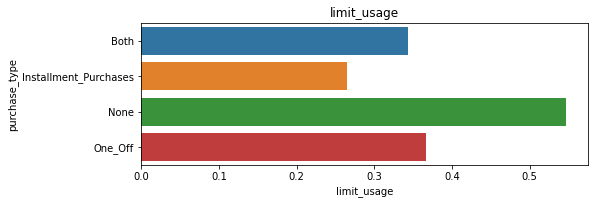

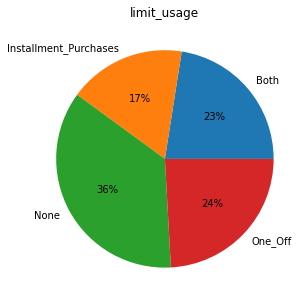

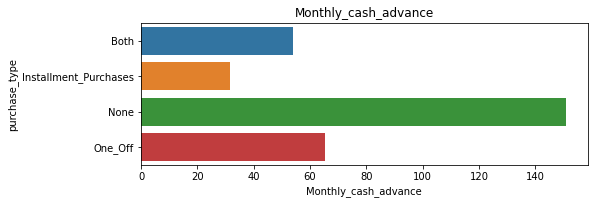

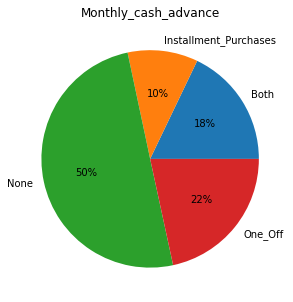

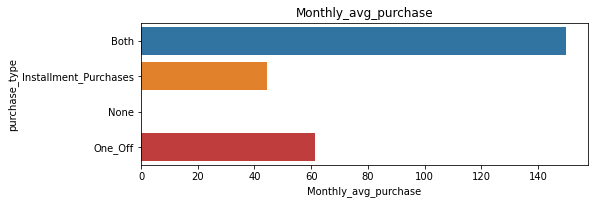

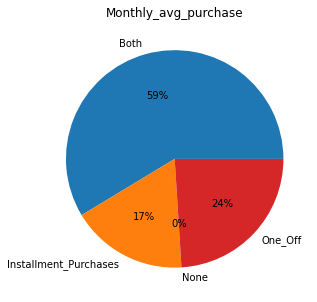

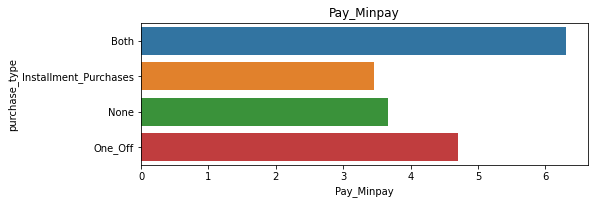

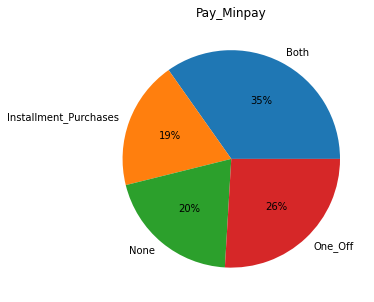

In [20]:
#Visualizing KPIs
for a, b in enumerate(set(kpi_col).difference(['purchase_type'])):
    plt.figure(figsize = (8,12))
    plt.subplot(4, 1, a+1)
    plt.subplots_adjust(wspace = 2)
    plt.title(b)
    sns.barplot(x = b, y = 'purchase_type', data = kpi)
    plt.figure(figsize = (5,5))
    plt.title(b)
    plt.pie(x = b, data = kpi, labels = 'purchase_type', autopct = '%.f%%')
plt.show()


Observations:

    - Customers mostly makes both One off and Installments Purchases
    - Cash Advance is high for customers who do not make any purchases
    - Payments to Minimum_Payments ratio is high for Customers who makes both One off and Installments Purchases
    - Limit Usage is high for Customers who do not make any purchases

#### <a> Encoding Categorical Variables

In [21]:
data = dummy_var(data, 'purchase_type')

#### <a>Correlation Matrix

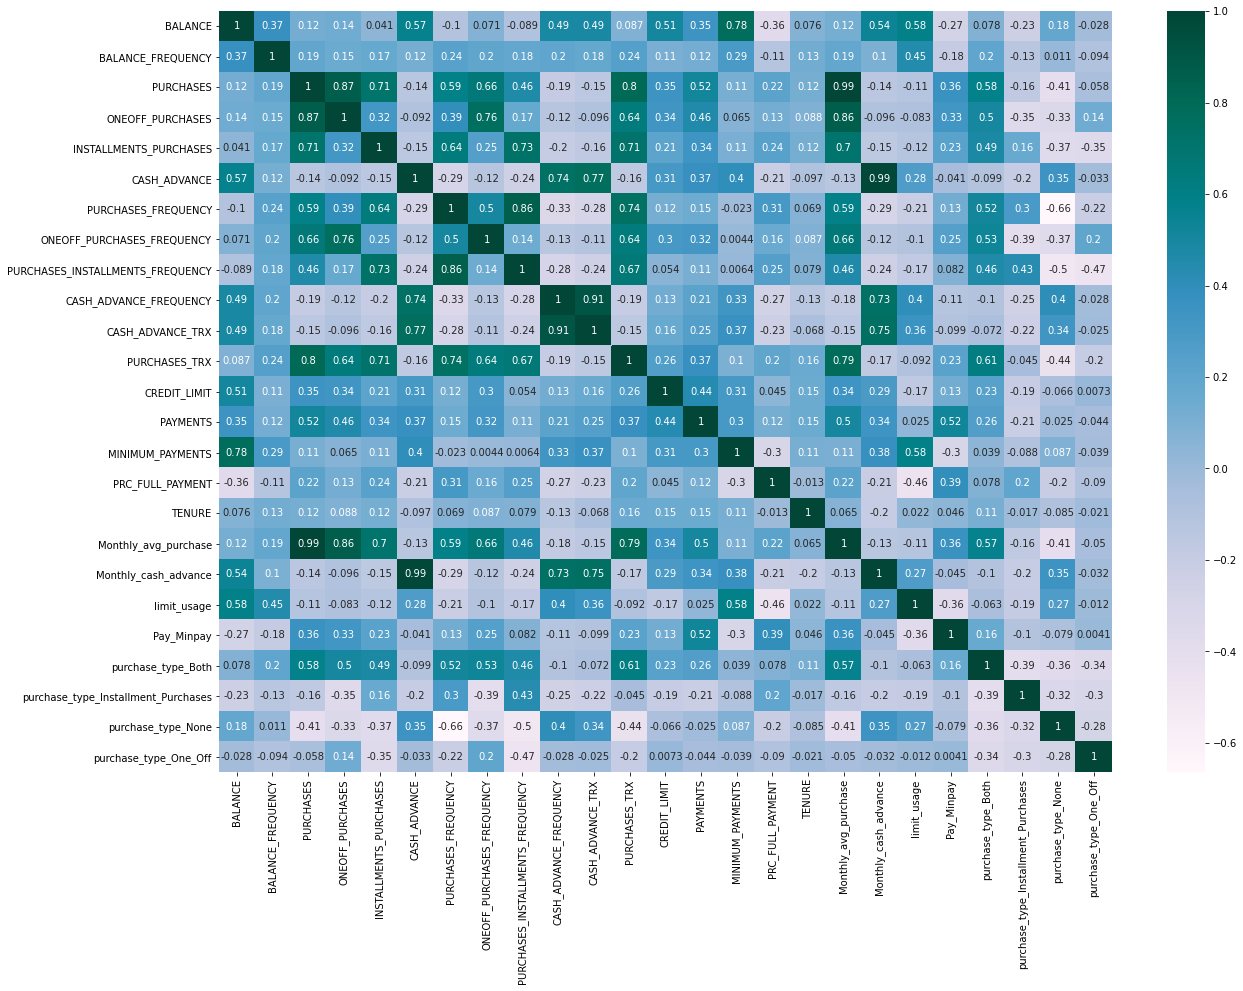

In [22]:
#Correlation Heatmap
plt.figure(figsize = (20,14))
sns.heatmap(data = data.corr(), annot = True, cmap = 'PuBuGn')
plt.show()

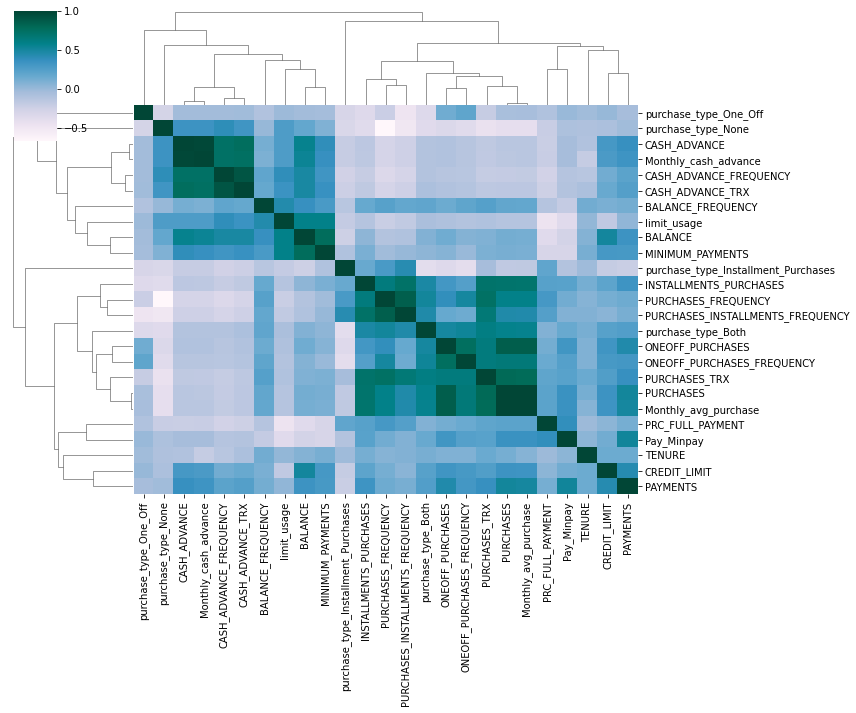

In [23]:
#Cluster Heatmap
sns.clustermap(data = data.corr(), cmap = 'PuBuGn', figsize=(12, 10))
plt.show()

#### <a>Standardizing the Dataset

In [24]:
sc = StandardScaler()
sc_data = pd.DataFrame(sc.fit_transform(data), columns = data.columns)
sc_data.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,Monthly_avg_purchase,Monthly_cash_advance,limit_usage,Pay_Minpay,purchase_type_Both,purchase_type_Installment_Purchases,purchase_type_None,purchase_type_One_Off
0,-0.835766,-0.297832,-0.662456,-0.600439,-0.484060,-0.605629,-0.806649,-0.678716,-0.707409,-0.722442,-0.636316,-0.680503,-1.049776,-0.800361,-0.689556,-0.525588,0.379019,-0.669571,-0.595573,-0.974262,-0.469671,-0.670247,1.720388,-0.543557,-0.514661
1,1.036898,0.118351,-0.749201,-0.600439,-0.675697,2.840367,-1.221928,-0.678716,-0.917090,0.693151,0.295892,-0.807873,0.821678,1.644239,0.623650,0.234159,0.379019,-0.754602,2.574007,0.240597,-0.121025,-0.670247,-0.581264,1.839732,-0.514661
2,0.617938,0.534535,-0.046178,0.435817,-0.675697,-0.605629,1.269742,2.673295,-0.917090,-0.722442,-0.636316,-0.043652,0.977633,-0.537013,-0.002883,-0.525588,0.379019,-0.065465,-0.595573,-0.123366,-0.536306,-0.670247,-0.581264,-0.543557,1.943025
3,0.127212,-1.130199,0.613801,1.408625,-0.675697,-0.453032,-1.014290,-0.399383,-0.917090,-0.250580,-0.403264,-0.744188,0.977633,-0.870425,-0.446246,-0.525588,0.379019,0.581478,-0.455217,-0.445497,-0.639384,-0.670247,-0.581264,-0.543557,1.943025
4,-0.375643,0.534535,-0.734652,-0.578995,-0.675697,-0.605629,-1.014290,-0.399383,-0.917090,-0.722442,-0.636316,-0.744188,-0.987394,-0.501754,-0.541344,-0.525588,0.379019,-0.740341,-0.595573,0.893624,-0.275614,-0.670247,-0.581264,-0.543557,1.943025


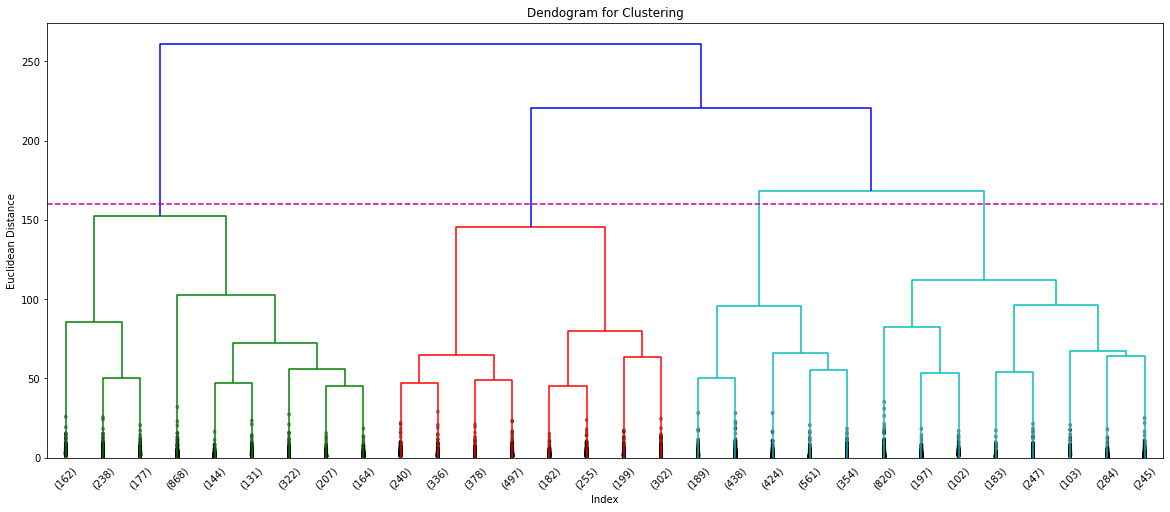

In [25]:
#Dendogram for chosing number of clusters
link = sch.linkage(sc_data, method = 'ward')
plt.figure(figsize = (20,8))
den = sch.dendrogram(link, truncate_mode='lastp', show_contracted=True)
plt.axhline(y=160, color='m', linestyle='--', animated = True, dash_joinstyle = 'round')
plt.title('Dendogram for Clustering')
plt.xlabel('Index')
plt.ylabel('Euclidean Distance')
plt.show()

From Dendogram, the optimal value of k is 4.

#### <a>Applying PCA : Principal Component Analysis

In [26]:
#Total Features
sc_data.shape[1]

25

In [27]:
#Initializing PCA and getting variance ratio of each component
var_ratio = {}

for n in range(2,15):
    pc = PCA(n_components = n)
    pc_data = pc.fit(sc_data)
    var_ratio[n]=sum(pc_data.explained_variance_ratio_)

In [28]:
#Variance Ratio of Components
var_ratio

{2: 0.49077642120685505,
 3: 0.5886160666102027,
 4: 0.6689946164395613,
 5: 0.720024341686191,
 6: 0.7680134870689663,
 7: 0.8048118701341238,
 8: 0.8405035946103462,
 9: 0.8701233404354229,
 10: 0.8917283199672011,
 11: 0.9127387797239842,
 12: 0.9305544691797282,
 13: 0.9454013956456228,
 14: 0.9587065789393219}

Since 7 Components explains 84% variance of the data, we select 7 components.

In [29]:
pc = PCA(n_components = 8)
reduced_cr = pc.fit_transform(sc_data)
pc_data = pd.DataFrame(reduced_cr)
pc_data.head()

,0,1,2,3,4,5,6,7
0,-1.322370,-2.829545,-0.553556,0.021265,0.438369,-0.294131,-0.017016,-0.047815
1,-3.168242,3.096572,0.565004,1.880559,0.185395,-1.302169,-0.218989,0.064496
2,0.858825,-0.089216,1.512842,-2.654774,1.607600,0.629968,-0.554411,-0.837245
3,-0.379996,-0.599368,2.226609,-1.556673,1.539105,-0.029130,-0.771256,0.673246
4,-1.762148,-1.548333,0.884079,-2.147090,0.468886,0.050270,0.996227,-0.537901


In [30]:
#Reduced data features
pc_data.shape[1]

8

In [31]:
#Principal Componenet Data
pd.DataFrame(pc.components_.T, columns = ['PC_' + str(i) for i in range(8)], index = sc_data.columns)

,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7
BALANCE,-0.046549,0.364350,-0.137005,-0.144986,0.194877,-0.126725,-0.103910,0.165378
BALANCE_FREQUENCY,0.054038,0.183916,-0.218749,-0.241955,-0.152282,0.024977,0.290873,-0.373692
PURCHASES,0.329222,0.140406,0.083577,-0.028148,-0.017927,-0.008609,0.115088,0.181946
ONEOFF_PURCHASES,0.268003,0.150658,0.258909,-0.144182,-0.019726,0.061646,0.064475,0.115191
INSTALLMENTS_PURCHASES,0.278952,0.060579,-0.224298,0.146979,-0.038127,-0.078151,0.074439,0.152003
CASH_ADVANCE,-0.147850,0.332710,0.009193,0.265148,0.086804,0.120521,-0.062522,-0.085988
PURCHASES_FREQUENCY,0.306081,-0.022565,-0.233753,0.037268,0.086815,0.226837,-0.019729,-0.176908
ONEOFF_PURCHASES_FREQUENCY,0.249620,0.116780,0.245176,-0.195843,-0.033265,0.184529,-0.063697,-0.169092
PURCHASES_INSTALLMENTS_FREQUENCY,0.258156,-0.036056,-0.388461,0.159173,-0.005508,0.081632,-0.038231,-0.064062
CASH_ADVANCE_FREQUENCY,-0.170237,0.307582,-0.011321,0.156454,-0.105702,0.212142,0.072666,-0.209150


In [32]:
#Variance explained by each component
pd.Series(pc.explained_variance_ratio_,index=['PC_'+ str(i) for i in range(8)])

PC_0    0.285801
PC_1    0.204975
PC_2    0.097840
PC_3    0.080379
PC_4    0.051030
PC_5    0.047989
PC_6    0.036798
PC_7    0.035692
dtype: float64

<AxesSubplot:>

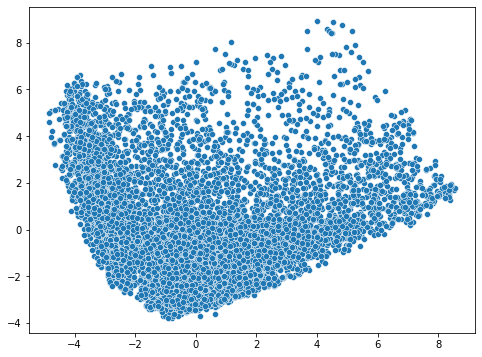

In [33]:
#Scatterplot of transformed data
plt.figure(figsize = (8,6))
sns.scatterplot(reduced_cr[:,0], reduced_cr[:,1])

#### <a>Clustering

Based on the type of purchases made by the customers, we start with k = 4.

In [34]:
km_4 = KMeans(n_clusters = 4, random_state = 123, n_init = 100, n_jobs = -1)

In [35]:
km_4.fit(reduced_cr)

KMeans(n_clusters=4, n_init=100, n_jobs=-1, random_state=123)

In [36]:
km_4.labels_

array([2, 0, 1, ..., 2, 1, 1])

In [37]:
pd.Series(km_4.labels_).value_counts()

1    3077
2    2689
3    1649
0    1534
dtype: int64

<AxesSubplot:>

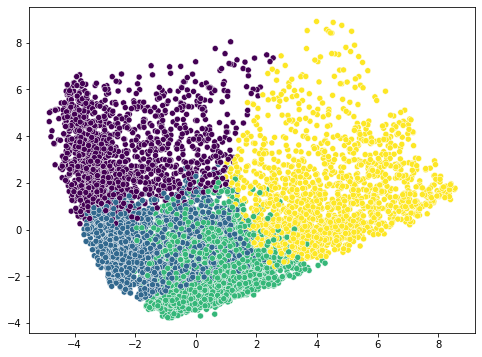

In [38]:
#Scatterplot of 4 clusters
plt.figure(figsize = (8,6))
sns.scatterplot(reduced_cr[:,0], reduced_cr[:,1], c = km_4.labels_.astype(int))

In [39]:
#Calculating Silhouette Score for K = 3 to 8
k_range = range(3,9)
scores = []
for k in k_range :
    km = KMeans(n_clusters = k, random_state = 123)
    km.fit(reduced_cr)
    scores.append(silhouette_score(reduced_cr,km.labels_))

In [40]:
scores

[0.24287940541385966,
 0.22556086187595425,
 0.2563244891902331,
 0.2633410182224721,
 0.2647555988233583,
 0.2643062838579262]

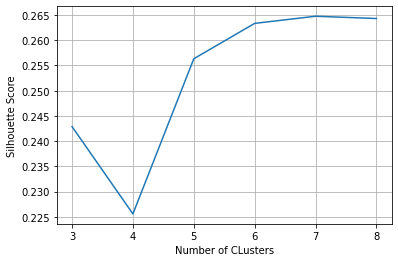

In [41]:
#Plotting the results
plt.plot(k_range, scores)
plt.xlabel('Number of CLusters')
plt.ylabel('Silhouette Score')
plt.grid(True)

Based of Silhouette Score, optimal value of k lies between 5 to 7

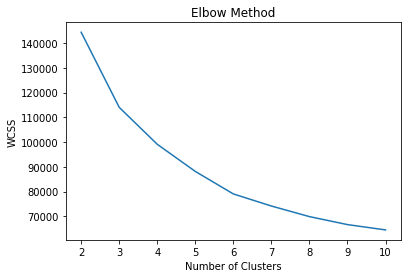

In [42]:
#Pseudo F-Score(Elbow Method)
wcss = []
for i in range(2,11):
    km = KMeans(n_clusters = i, random_state = 123)
    km.fit(reduced_cr)
    wcss.append(km.inertia_)
plt.plot(range(2,11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

Based of Pseudo F-Score, optimal k value lies between 3 to 5

In [43]:
#Building Cluster with k value from 3 to 7
km_3 = KMeans(n_clusters = 3, random_state = 123, n_init = 20, n_jobs = -1).fit(reduced_cr)
km_4 = KMeans(n_clusters = 4, random_state = 123, n_init = 20, n_jobs = -1).fit(reduced_cr)
km_5 = KMeans(n_clusters = 5, random_state = 123, n_init = 20, n_jobs = -1).fit(reduced_cr)
km_6 = KMeans(n_clusters = 6, random_state = 123, n_init = 20, n_jobs = -1).fit(reduced_cr)
km_7 = KMeans(n_clusters = 7, random_state = 123, n_init = 20, n_jobs = -1).fit(reduced_cr)

In [44]:
data['Cluster_3'] = km_3.labels_
data['Cluster_4'] = km_4.labels_
data['Cluster_5'] = km_5.labels_
data['Cluster_6'] = km_6.labels_
data['Cluster_7'] = km_7.labels_

In [45]:
data.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,Monthly_avg_purchase,Monthly_cash_advance,limit_usage,Pay_Minpay,purchase_type_Both,purchase_type_Installment_Purchases,purchase_type_None,purchase_type_One_Off,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12,7.950000,0.000000,0.040901,1.446508,0,1,0,0,2,0,2,1,0
1,3202.467416,0.909091,0.00,0.00,0.0,4647.169122,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12,0.000000,387.264093,0.457495,3.826241,0,0,1,0,0,2,3,0,2
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12,64.430833,0.000000,0.332687,0.991682,0,0,0,1,2,1,0,5,4
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,89.988924,312.343947,0.000000,12,124.916667,17.149001,0.222223,0.288108,0,0,0,1,2,1,0,5,4
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12,1.333333,0.000000,0.681429,2.771075,0,0,0,1,2,1,0,5,4


#### <a> Manual Profiling

In [46]:
data.Cluster_7.value_counts()

0    2049
3    1606
4    1504
1    1499
2    1103
5     605
6     583
Name: Cluster_7, dtype: int64

In [47]:
#Creating Profile DataFrame
profile = pd.concat([data.apply(lambda x: x.mean()).T,
                     data.groupby('Cluster_3').apply(lambda x: x.mean()).T,
                     data.groupby('Cluster_4').apply(lambda x: x.mean()).T,
                     data.groupby('Cluster_5').apply(lambda x: x.mean()).T,
                     data.groupby('Cluster_6').apply(lambda x: x.mean()).T,
                     data.groupby('Cluster_7').apply(lambda x: x.mean()).T],
                     axis = 1, )

In [48]:
#Naming Profile Columns
profile.columns = ['Overall', 'KM3_1', 'KM3_2', 'KM3_3',
                              'KM4_1', 'KM4_2', 'KM4_3', 'KM4_4',
                              'KM5_1', 'KM5_2', 'KM5_3', 'KM5_4', 'KM5_5',
                              'KM6_1', 'KM6_2', 'KM6_3', 'KM6_4', 'KM6_5', 'KM6_6',
                              'KM7_1', 'KM7_2', 'KM7_3', 'KM7_4', 'KM7_5', 'KM7_6', 'KM7_7']

profile

,Overall,KM3_1,KM3_2,KM3_3,KM4_1,KM4_2,KM4_3,KM4_4,KM5_1,KM5_2,KM5_3,KM5_4,KM5_5,KM6_1,KM6_2,KM6_3,KM6_4,KM6_5,KM6_6,KM7_1,KM7_2,KM7_3,KM7_4,KM7_5,KM7_6,KM7_7
BALANCE,1451.901581,2544.484127,1896.304347,576.572843,493.822773,1062.575213,3466.266879,1844.357357,944.273845,1876.902122,565.543827,3922.116871,1404.398513,3981.023566,509.391492,2128.353391,1402.783820,1000.815279,917.716842,487.307650,901.739890,3918.892561,1395.441441,910.993873,660.344973,3961.586334
BALANCE_FREQUENCY,0.883239,0.935313,0.971518,0.815095,0.833859,0.845152,0.948278,0.972593,0.820459,0.974445,0.844349,0.962769,0.874640,0.962059,0.820360,0.972497,0.871580,0.928277,0.815860,0.819956,0.923766,0.959920,0.871533,0.815551,0.952375,0.991494
PURCHASES,823.955084,176.863686,2689.782856,503.931653,544.505038,307.382406,303.254256,2705.923475,588.458616,2808.729097,555.449151,438.618307,14.496254,405.991140,486.719402,3336.246181,4.433387,1012.585032,577.634437,470.643724,973.927011,336.731097,4.182802,561.290020,3197.656513,3074.466736
ONEOFF_PURCHASES,447.998786,114.452443,1541.141512,231.296634,68.633411,288.370863,180.912419,1592.720851,578.784304,1633.659623,103.467535,257.389886,8.975663,238.375632,0.258012,1956.466874,2.012740,545.111982,570.964669,0.050220,530.823492,208.951378,1.791065,555.855040,1923.203183,1681.715424
INSTALLMENTS_PURCHASES,336.373624,61.688731,953.530771,269.393300,462.472333,18.709306,118.050156,926.633224,3.959050,976.670528,440.080323,172.204125,5.520591,161.704330,466.680728,1098.019808,2.420647,462.930097,0.071039,456.165617,439.635889,124.737448,2.391737,0.017008,1009.707194,1139.253937
CASH_ADVANCE,816.733164,2090.862413,515.358908,118.736315,114.760428,456.444045,3167.898872,438.648605,254.707566,419.540589,125.452687,3523.834491,1044.187435,3581.825663,124.636975,519.700918,1058.461572,222.654335,260.696968,122.870253,202.451969,3580.998479,1042.177646,261.334951,130.557311,1128.807674
PURCHASES_FREQUENCY,0.490405,0.141084,0.910935,0.548700,0.729294,0.192022,0.227265,0.906889,0.316414,0.917785,0.705292,0.305976,0.015491,0.288412,0.706070,0.929507,0.006518,0.739668,0.309034,0.704919,0.730479,0.258609,0.006421,0.307112,0.920253,0.917775
ONEOFF_PURCHASES_FREQUENCY,0.202480,0.063159,0.586550,0.140529,0.048908,0.166892,0.096458,0.610048,0.313130,0.621785,0.070672,0.131293,0.006585,0.124468,0.000302,0.673462,0.001717,0.321835,0.308742,0.000122,0.316825,0.110997,0.001623,0.306890,0.705132,0.555099
PURCHASES_INSTALLMENTS_FREQUENCY,0.364478,0.082177,0.710840,0.409023,0.675363,0.029840,0.145163,0.693592,0.006271,0.720224,0.638586,0.198246,0.009985,0.184249,0.669743,0.734472,0.004591,0.573979,0.000277,0.668588,0.562349,0.158442,0.004586,0.000111,0.687485,0.772889
CASH_ADVANCE_FREQUENCY,0.127587,0.306303,0.077454,0.032777,0.025902,0.111880,0.398104,0.069511,0.064791,0.066553,0.030336,0.413934,0.215207,0.416263,0.024354,0.072701,0.216352,0.059410,0.066395,0.024298,0.057240,0.417329,0.214276,0.066214,0.025806,0.148444


In [49]:
#Getting size of clusters
size = pd.concat([pd.Series(len(data)),
                  pd.Series.sort_index(data.Cluster_3.value_counts()),
                  pd.Series.sort_index(data.Cluster_4.value_counts()),
                  pd.Series.sort_index(data.Cluster_5.value_counts()),
                  pd.Series.sort_index(data.Cluster_6.value_counts()),
                  pd.Series.sort_index(data.Cluster_7.value_counts())])

size = pd.DataFrame(size.reset_index(drop = True), columns = ['Seg_size'])
size.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
Seg_size,8949,2819,1732,4398,2650,3097,1534,1668,1590,1506,3002,1177,1674,1131,2072,1027,1624,1574,1521,2049,1499,1103,1606,1504,605,583


In [50]:
#Getting cluster percentage
perc = pd.DataFrame((size.values/data.Cluster_3.size), columns = ['Seg_perc'])
perc.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
Seg_perc,1.0,0.315007,0.193541,0.491452,0.296122,0.346072,0.171416,0.18639,0.177673,0.168287,0.335456,0.131523,0.18706,0.126383,0.231534,0.114761,0.181473,0.175886,0.169963,0.228964,0.167505,0.123254,0.179461,0.168063,0.067605,0.065147


In [51]:
size_perc = pd.concat([size.T, perc.T])
size_perc.columns = ['Overall', 'KM3_1', 'KM3_2', 'KM3_3',
                              'KM4_1', 'KM4_2', 'KM4_3', 'KM4_4',
                              'KM5_1', 'KM5_2', 'KM5_3', 'KM5_4', 'KM5_5',
                              'KM6_1', 'KM6_2', 'KM6_3', 'KM6_4', 'KM6_5', 'KM6_6',
                              'KM7_1', 'KM7_2', 'KM7_3', 'KM7_4', 'KM7_5', 'KM7_6', 'KM7_7']
size_perc

,Overall,KM3_1,KM3_2,KM3_3,KM4_1,KM4_2,KM4_3,KM4_4,KM5_1,KM5_2,KM5_3,KM5_4,KM5_5,KM6_1,KM6_2,KM6_3,KM6_4,KM6_5,KM6_6,KM7_1,KM7_2,KM7_3,KM7_4,KM7_5,KM7_6,KM7_7
Seg_size,8949.0,2819.000000,1732.000000,4398.000000,2650.000000,3097.000000,1534.000000,1668.00000,1590.000000,1506.000000,3002.000000,1177.000000,1674.00000,1131.000000,2072.000000,1027.000000,1624.000000,1574.000000,1521.000000,2049.000000,1499.000000,1103.000000,1606.000000,1504.000000,605.000000,583.000000
Seg_perc,1.0,0.315007,0.193541,0.491452,0.296122,0.346072,0.171416,0.18639,0.177673,0.168287,0.335456,0.131523,0.18706,0.126383,0.231534,0.114761,0.181473,0.175886,0.169963,0.228964,0.167505,0.123254,0.179461,0.168063,0.067605,0.065147


In [52]:
profile_final = pd.concat([size_perc, profile])
profile_final.to_excel('Profile_Output.xlsx')
profile_final

,Overall,KM3_1,KM3_2,KM3_3,KM4_1,KM4_2,KM4_3,KM4_4,KM5_1,KM5_2,KM5_3,KM5_4,KM5_5,KM6_1,KM6_2,KM6_3,KM6_4,KM6_5,KM6_6,KM7_1,KM7_2,KM7_3,KM7_4,KM7_5,KM7_6,KM7_7
Seg_size,8949.000000,2819.000000,1732.000000,4398.000000,2650.000000,3097.000000,1534.000000,1668.000000,1590.000000,1506.000000,3002.000000,1177.000000,1674.000000,1131.000000,2072.000000,1027.000000,1624.000000,1574.000000,1521.000000,2049.000000,1499.000000,1103.000000,1606.000000,1504.000000,605.000000,583.000000
Seg_perc,1.000000,0.315007,0.193541,0.491452,0.296122,0.346072,0.171416,0.186390,0.177673,0.168287,0.335456,0.131523,0.187060,0.126383,0.231534,0.114761,0.181473,0.175886,0.169963,0.228964,0.167505,0.123254,0.179461,0.168063,0.067605,0.065147
BALANCE,1451.901581,2544.484127,1896.304347,576.572843,493.822773,1062.575213,3466.266879,1844.357357,944.273845,1876.902122,565.543827,3922.116871,1404.398513,3981.023566,509.391492,2128.353391,1402.783820,1000.815279,917.716842,487.307650,901.739890,3918.892561,1395.441441,910.993873,660.344973,3961.586334
BALANCE_FREQUENCY,0.883239,0.935313,0.971518,0.815095,0.833859,0.845152,0.948278,0.972593,0.820459,0.974445,0.844349,0.962769,0.874640,0.962059,0.820360,0.972497,0.871580,0.928277,0.815860,0.819956,0.923766,0.959920,0.871533,0.815551,0.952375,0.991494
PURCHASES,823.955084,176.863686,2689.782856,503.931653,544.505038,307.382406,303.254256,2705.923475,588.458616,2808.729097,555.449151,438.618307,14.496254,405.991140,486.719402,3336.246181,4.433387,1012.585032,577.634437,470.643724,973.927011,336.731097,4.182802,561.290020,3197.656513,3074.466736
ONEOFF_PURCHASES,447.998786,114.452443,1541.141512,231.296634,68.633411,288.370863,180.912419,1592.720851,578.784304,1633.659623,103.467535,257.389886,8.975663,238.375632,0.258012,1956.466874,2.012740,545.111982,570.964669,0.050220,530.823492,208.951378,1.791065,555.855040,1923.203183,1681.715424
INSTALLMENTS_PURCHASES,336.373624,61.688731,953.530771,269.393300,462.472333,18.709306,118.050156,926.633224,3.959050,976.670528,440.080323,172.204125,5.520591,161.704330,466.680728,1098.019808,2.420647,462.930097,0.071039,456.165617,439.635889,124.737448,2.391737,0.017008,1009.707194,1139.253937
CASH_ADVANCE,816.733164,2090.862413,515.358908,118.736315,114.760428,456.444045,3167.898872,438.648605,254.707566,419.540589,125.452687,3523.834491,1044.187435,3581.825663,124.636975,519.700918,1058.461572,222.654335,260.696968,122.870253,202.451969,3580.998479,1042.177646,261.334951,130.557311,1128.807674
PURCHASES_FREQUENCY,0.490405,0.141084,0.910935,0.548700,0.729294,0.192022,0.227265,0.906889,0.316414,0.917785,0.705292,0.305976,0.015491,0.288412,0.706070,0.929507,0.006518,0.739668,0.309034,0.704919,0.730479,0.258609,0.006421,0.307112,0.920253,0.917775
ONEOFF_PURCHASES_FREQUENCY,0.202480,0.063159,0.586550,0.140529,0.048908,0.166892,0.096458,0.610048,0.313130,0.621785,0.070672,0.131293,0.006585,0.124468,0.000302,0.673462,0.001717,0.321835,0.308742,0.000122,0.316825,0.110997,0.001623,0.306890,0.705132,0.555099


#### <a> Based on Dendogram, Pseudo F-Score and Manual Profiling, the optimal value of k is 4.
    
Based on 4 Cluster solution : 
    
    - Cluster 1 contains Customers with Low Income making mostly installment purchases. They are loyal and pay their due balance mostly on time. These Customers can be provided with No Cost EMI offers. 
    
    - Cluster 2 contains Customers with Low Income making low purchases. Customers mostly makes One Off Purchases and are not able to pay due balance on time. These Customers can be provided low interest rate and special discounts offer on One Off purchases.
    
    - Cluster 3 contains customers making low purchases but have high Balance and high Cash Advance amount and are not able to pay due balance on time.
    
    - Cluster 4 contains customers with High Income making high purchases. Their Cash Advance is low and Credit Limit is High. These customer purchases both One Off and Installment Purchases. They also makes payments of their bill mostly on time. These customers are loyal and can be provided with special discounts and No Cost EMI offers.
    

<AxesSubplot:>

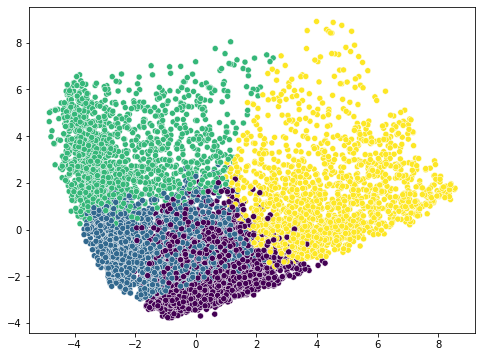

In [53]:
#Scatterplot of 4 clusters
plt.figure(figsize = (8,6))
sns.scatterplot(reduced_cr[:,0], reduced_cr[:,1], c = km_4.labels_.astype(int))